In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("ggplot")
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
import math

In [2]:
df = pd.read_csv('/content/GOOGL-2013_2023.csv')

In [3]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-03-11,20.813063,21.013514,20.808308,20.891392,20.891392,63724212
1,2013-03-12,20.788540,20.818068,20.612362,20.710960,20.710960,80251668
2,2013-03-13,20.718218,20.788038,20.578327,20.653402,20.653402,65586348
3,2013-03-14,20.695444,20.695444,20.455206,20.559059,20.559059,65981952
4,2013-03-15,20.482983,20.528028,20.353853,20.377878,20.377878,123864012


In [4]:
df.shape

(2518, 7)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2518 entries, 0 to 2517
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2518 non-null   object 
 1   Open       2518 non-null   float64
 2   High       2518 non-null   float64
 3   Low        2518 non-null   float64
 4   Close      2518 non-null   float64
 5   Adj Close  2518 non-null   float64
 6   Volume     2518 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 137.8+ KB


In [6]:
df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [7]:
df['Date'] = pd.to_datetime(df.Date)
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-03-11,20.813063,21.013514,20.808308,20.891392,20.891392,63724212
1,2013-03-12,20.788540,20.818068,20.612362,20.710960,20.710960,80251668
2,2013-03-13,20.718218,20.788038,20.578327,20.653402,20.653402,65586348
3,2013-03-14,20.695444,20.695444,20.455206,20.559059,20.559059,65981952
4,2013-03-15,20.482983,20.528028,20.353853,20.377878,20.377878,123864012


In [8]:
print("Starting date: ",df.iloc[0][0])
print("Ending date: ", df.iloc[-1][0])
print("Duration: ", df.iloc[-1][0]- df.iloc[0][0])

Starting date:  2013-03-11 00:00:00
Ending date:  2023-03-09 00:00:00
Duration:  3650 days 00:00:00


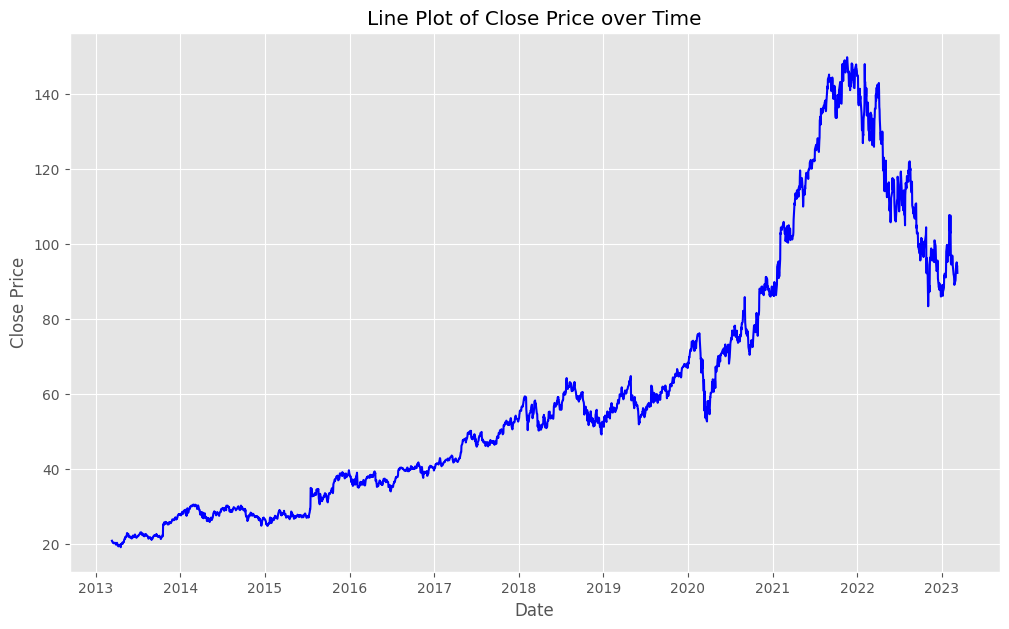

In [9]:
plt.figure(figsize=(12,7))
sns.lineplot(data=df,x="Date",y="Close",color="blue")

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Line Plot of Close Price over Time')
plt.grid(True)
plt.show()

In [10]:
df_close = df['Close']
df_close.head()

0    20.891392
1    20.710960
2    20.653402
3    20.559059
4    20.377878
Name: Close, dtype: float64

In [11]:
df_close.shape

(2518,)

In [12]:
scaler=MinMaxScaler(feature_range=(0,1))
df_close=scaler.fit_transform(np.array(df_close).reshape(-1,1))
df_close.shape

(2518, 1)

In [13]:
df_close

array([[0.01319701],
       [0.0118162 ],
       [0.01137573],
       ...,
       [0.57160923],
       [0.5745938 ],
       [0.55982395]])

In [14]:
df_close = pd.DataFrame(df_close)

training_size = int(len(df_close) * 0.65)
test_size = len(df_close) - training_size
train_data, test_data = df_close[0:training_size], df_close[training_size:len(df_close)]

In [15]:
print(train_data),print(test_data)

             0
0     0.013197
1     0.011816
2     0.011376
3     0.010654
4     0.009267
...        ...
1631  0.308863
1632  0.300835
1633  0.305702
1634  0.317151
1635  0.314905

[1636 rows x 1 columns]
             0
1636  0.314503
1637  0.314667
1638  0.320139
1639  0.325867
1640  0.327803
...        ...
2513  0.570002
2514  0.581328
2515  0.571609
2516  0.574594
2517  0.559824

[882 rows x 1 columns]


(None, None)

In [16]:
def create_dataset(dataset, time_step=1):
    x_data, y_data = [], []

    for i in range(len(dataset)-time_step-1):
        x_data.append(dataset.iloc[i:(i+time_step), 0].values)
        y_data.append(dataset.iloc[i + time_step, 0])
    return np.array(x_data), np.array(y_data)

In [17]:
time_step = 100

X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [18]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1535, 100)
(1535,)
(781, 100)
(781,)


In [19]:
X_train,y_train

(array([[0.01319701, 0.0118162 , 0.01137573, ..., 0.02228419, 0.02394077,
         0.02333367],
        [0.0118162 , 0.01137573, 0.01065374, ..., 0.02394077, 0.02333367,
         0.02648786],
        [0.01137573, 0.01065374, 0.0092672 , ..., 0.02333367, 0.02648786,
         0.02693791],
        ...,
        [0.31495432, 0.31615582, 0.3211837 , ..., 0.30244205, 0.31028234,
         0.30886274],
        [0.31615582, 0.3211837 , 0.32263772, ..., 0.31028234, 0.30886274,
         0.30083498],
        [0.3211837 , 0.32263772, 0.32469633, ..., 0.30886274, 0.30083498,
         0.30570213]]),
 array([0.02648786, 0.02693791, 0.02663724, ..., 0.30083498, 0.30570213,
        0.31715069]))

In [20]:
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [21]:
print(X_train.shape)
print(X_test.shape)

(1535, 100, 1)
(781, 100, 1)


In [22]:
model = Sequential()

model.add(LSTM(units = 256, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.1))


model.add(LSTM(units = 128, return_sequences = True))
model.add(Dropout(0.1))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.1))


model.add(LSTM(units = 50))
model.add(Dropout(0.1))


model.add(Dense(units = 1, activation = 'relu'))
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 256)          264192    
                                                                 
 dropout (Dropout)           (None, 100, 256)          0         
                                                                 
 lstm_1 (LSTM)               (None, 100, 128)          197120    
                                                                 
 dropout_1 (Dropout)         (None, 100, 128)          0         
                                                                 
 lstm_2 (LSTM)               (None, 100, 50)           35800     
                                                                 
 dropout_2 (Dropout)         (None, 100, 50)           0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                2

In [24]:
history = model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=32,verbose=1)

Epoch 1/100
48/48 [==============================] - 19s 63ms/step - loss: 0.0037 - val_loss: 0.0223
Epoch 2/100
48/48 [==============================] - 1s 29ms/step - loss: 4.7091e-04 - val_loss: 0.0105
Epoch 3/100
48/48 [==============================] - 1s 22ms/step - loss: 3.8355e-04 - val_loss: 0.0110
Epoch 4/100
48/48 [==============================] - 1s 22ms/step - loss: 3.2014e-04 - val_loss: 0.0102
Epoch 5/100
48/48 [==============================] - 1s 22ms/step - loss: 2.8903e-04 - val_loss: 0.0088
Epoch 6/100
48/48 [==============================] - 1s 22ms/step - loss: 3.5293e-04 - val_loss: 0.0107
Epoch 7/100
48/48 [==============================] - 1s 22ms/step - loss: 3.1149e-04 - val_loss: 0.0063
Epoch 8/100
48/48 [==============================] - 1s 22ms/step - loss: 2.5380e-04 - val_loss: 0.0049
Epoch 9/100
48/48 [==============================] - 1s 22ms/step - loss: 2.5791e-04 - val_loss: 0.0161
Epoch 10/100
48/48 [==============================] - 1s 22ms/step 

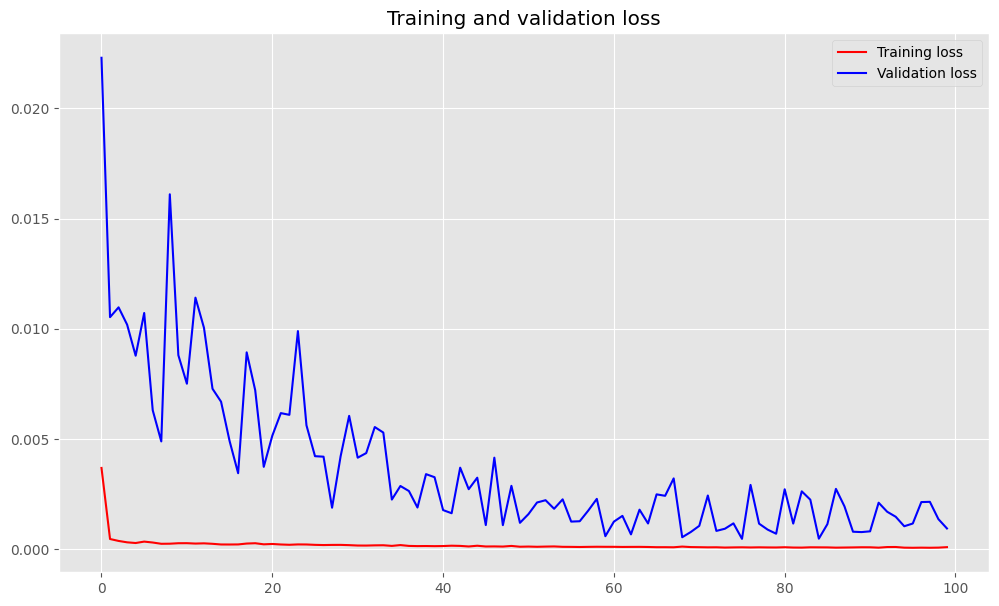

<Figure size 640x480 with 0 Axes>

In [25]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure(figsize=(12,7))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()

plt.show()

In [26]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
train_predict.shape, test_predict.shape

25/25 [==============================] - 0s 8ms/step


((1535, 1), (781, 1))

In [27]:
train_predict

array([[0.03323069],
       [0.03472489],
       [0.03593059],
       ...,
       [0.31286845],
       [0.3069321 ],
       [0.30745584]], dtype=float32)

In [28]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train = scaler.inverse_transform(y_train.reshape(-1,1))
y_test = scaler.inverse_transform(y_test.reshape(-1,1))

In [29]:
print(train_predict.shape)
print(test_predict.shape)
print(y_train.shape)
print(y_test.shape)

(1535, 1)
(781, 1)
(1535, 1)
(781, 1)


In [30]:
y_train

array([[22.628128],
       [22.686937],
       [22.647648],
       ...,
       [58.477501],
       [59.113499],
       [60.609501]])

In [31]:
print("Train data RMSE: ", math.sqrt(mean_squared_error(y_train,train_predict)))
print("Train data MSE: ", mean_squared_error(y_train,train_predict))
print("Train data MAE: ", mean_absolute_error(y_train,train_predict))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(y_test,test_predict)))
print("Test data MSE: ", mean_squared_error(y_test,test_predict))
print("Test data MAE: ", mean_absolute_error(y_test,test_predict))

Train data RMSE:  1.120029058564356
Train data MSE:  1.2544650920285576
Train data MAE:  0.9523604995334294
-------------------------------------------------------------------------------------
Test data RMSE:  4.02633615238324
Test data MSE:  16.211382811988273
Test data MAE:  3.1203043358284024


In [32]:
print("Train data R2 score:", r2_score(y_train, train_predict))
print("Test data R2 score:", r2_score(y_test, test_predict))

Train data R2 score: 0.9914416116995562
Test data R2 score: 0.9753378753440263


In [33]:
look_back=100
trainPredictPlot = np.empty_like(df_close)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict

testPredictPlot = np.empty_like(df_close)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df_close)-1, :] = test_predict

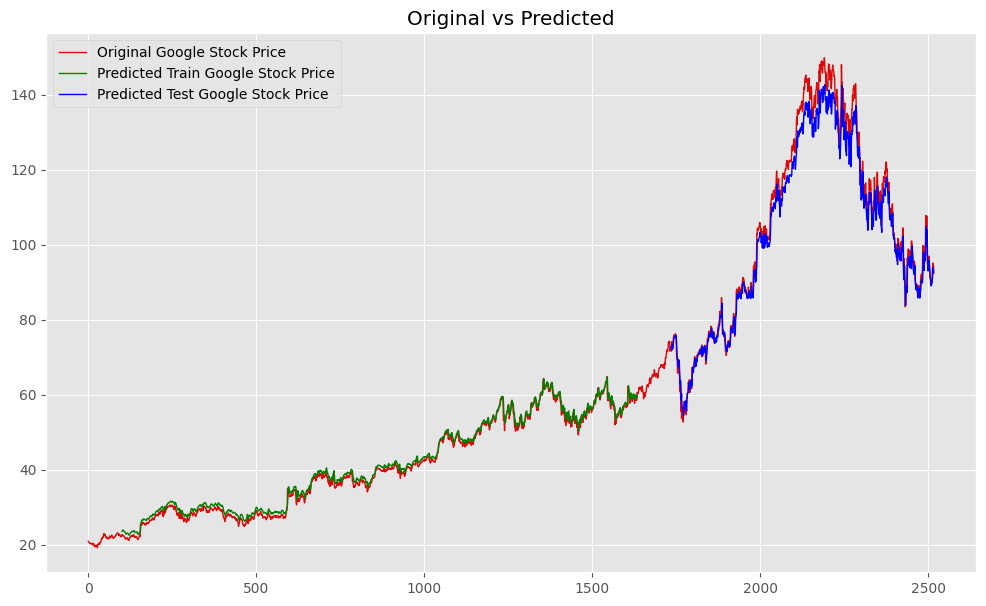

In [34]:
plt.figure(figsize=(12,7))
plt.plot(scaler.inverse_transform(df_close),color='#db0909',label='Original Google Stock Price',linewidth=1)
plt.plot(trainPredictPlot, color='green',label='Predicted Train Google Stock Price',linewidth=1)
plt.plot(testPredictPlot, color='blue',label='Predicted Test Google Stock Price',linewidth=1)
plt.title('Original vs Predicted')
plt.legend()
plt.show()

In [35]:
x_input=np.array(test_data[len(test_data)-time_step:]).reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

lst_output=[]
n_steps=time_step
i=0
pred_days = 30
while(i<pred_days):

    if(len(temp_input)>time_step):

        x_input=np.array(temp_input[1:])
        print("Day {} input {}".format(i,x_input))
        x_input = x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))

        yhat = model.predict(x_input, verbose=0)
        print("Day {} output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        print(temp_input)

        lst_output.extend(yhat.tolist())
        i=i+1

    else:

        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())

        lst_output.extend(yhat.tolist())
        i=i+1

print("Output of predicted next days: ", len(lst_output))

Day 1 input [0.61836768 0.62448986 0.6157657  0.61836768 0.62724486 0.63788222
 0.6528817  0.57979769 0.55905868 0.59020547 0.57658354 0.54566633
 0.51888162 0.4917908  0.51589705 0.53051381 0.53365148 0.52156009
 0.57222146 0.59112383 0.5856903  0.60665894 0.60979655 0.60604671
 0.59892962 0.58492503 0.59602159 0.60681197 0.5991592  0.58836882
 0.58178743 0.62617348 0.62617348 0.62196449 0.61461783 0.5954859
 0.57987423 0.5704613  0.56372688 0.56740018 0.58515461 0.58086908
 0.54865091 0.54405925 0.53013121 0.53456978 0.53885537 0.52492732
 0.53617691 0.52209577 0.51161146 0.5302077  0.52852413 0.5353351
 0.52737621 0.51298896 0.52171311 0.526917   0.52997812 0.55370171
 0.55071713 0.55829342 0.5519416  0.55064065 0.5654105  0.60344474
 0.61699018 0.60099585 0.582017   0.59961835 0.61377603 0.59517978
 0.60972    0.62188794 0.6778297  0.6551775  0.64079031 0.67706443
 0.61377603 0.58040993 0.57704269 0.57734881 0.5778845  0.59517978
 0.58423631 0.57535907 0.55576799 0.55469661 0.54888

In [36]:
lst_output[:5]

[[0.5513927936553955],
 [0.5435049533843994],
 [0.5372759103775024],
 [0.5324770212173462],
 [0.5284714698791504]]

In [37]:
last_days=np.arange(1,time_step+1)
day_pred=np.arange(time_step+1,time_step+pred_days+1)
print(last_days)
print(day_pred)

[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100]
[101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118
 119 120 121 122 123 124 125 126 127 128 129 130]


In [38]:
temp_mat = np.empty((len(last_days) + pred_days + 1, 1))
temp_mat[:] = np.nan
temp_mat = temp_mat.reshape(1, -1).tolist()[0]

last_original_days_value = temp_mat
next_predicted_days_value = temp_mat

last_original_days_value[0:time_step + 1] = scaler.inverse_transform(df_close[len(df_close) - time_step:]).reshape(1, -1).tolist()[0]
next_predicted_days_value[time_step + 1:] = scaler.inverse_transform(np.array(lst_output).reshape(-1, 1)).reshape(1, -1).tolist()[0]

new_pred_plot = pd.DataFrame({
    'last_original_days_value': last_original_days_value,
    'next_predicted_days_value': next_predicted_days_value
})

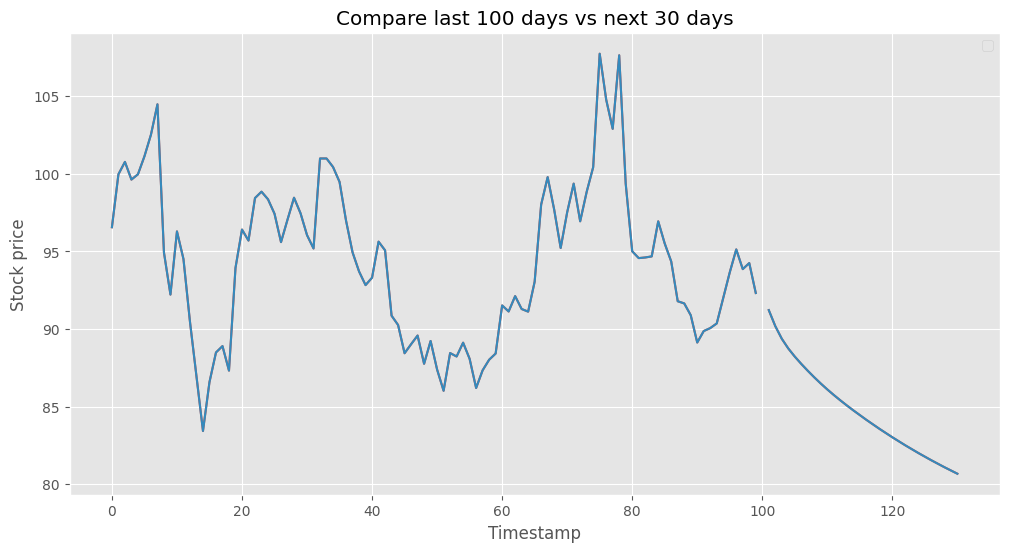

In [39]:
plt.figure(figsize=(12, 6))

plt.plot(new_pred_plot.index, new_pred_plot['last_original_days_value'])
plt.plot(new_pred_plot.index, new_pred_plot['next_predicted_days_value'])

plt.xlabel('Timestamp')
plt.ylabel('Stock price')
plt.title('Compare last 100 days vs next 30 days')
plt.grid(True)
plt.legend()
plt.show()

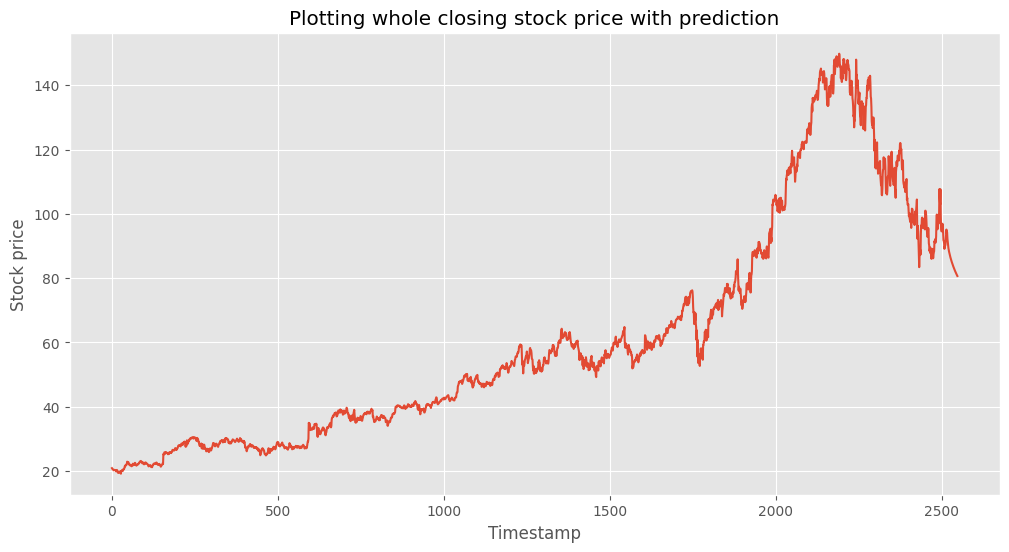

In [40]:
lstmdf = df_close.values.tolist()
lstmdf.extend((np.array(lst_output).reshape(-1, 1)).tolist())
lstmdf = scaler.inverse_transform(lstmdf).reshape(1, -1).tolist()[0]

plt.figure(figsize=(12,6))
plt.plot(lstmdf)

plt.xlabel('Timestamp')
plt.ylabel('Stock price')
plt.title('Plotting whole closing stock price with prediction')
plt.grid(True)
plt.show()